# NLP Processing of Offensive Tweets
Twitter is a social media platform that allows individuals and business to communicate directly with their fans and consumers. While this direct access has facilitated lots of great moments for the platform's users, it also exposes users to a fair amount of bile and harsh criticism while going through their comments section. In order to streamline the experience to the useful interactions, I'm hoping to build a classifier for filtering out insults from a user's mentions.

This notebook imports a dataset of offensive tweets developed for the paper ["Automated Hate Speech Detection and the Problem of Offensive Language", ICWSM 2017, by Thomas Davidson, Dana Warmsley, Michael Macy, and Ingmar Weber](https://github.com/t-davidson/hate-speech-and-offensive-language) and attempts to replicate a classifier that can then be used to predict direct insults and blatantly offensive tweets.  

**Please be aware that there is a fair amount of explicit language in this notebook due to the subject matter.**

In [31]:
# Data containers
import pandas as pd
import numpy as np
import pickle as pkl
import requests

# NLP methods and objects
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities, matutils
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

# Text decomposition
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF

# Classification tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate,\
    GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix,\
    accuracy_score, f1_score, roc_curve

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
# python LDA visualizer
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Custom functions that streamline model evaluation, dataframe merging, and transformations
from nlp_manipulation import prep_nlp_df, cross_val_and_test, lda_to_array

In [2]:
# Load set of cleaned text tweets and associated features
path = './data/labeled_cleaned_tweets.csv'
tweet_df = pd.read_csv(path, header=0, index_col=0)

# Tweets with no remaining text after scrubbing are read in as 'nan' values. Replace with empty string.
tweet_df.text = tweet_df.text.fillna(value='')

tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 24782
Data columns (total 10 columns):
class      24783 non-null int64
text       24783 non-null object
n_rt       24783 non-null int64
mention    24783 non-null int64
link       24783 non-null int64
n_emoji    24783 non-null int64
n_char     24783 non-null int64
avg_wrd    24783 non-null float64
emoji      24783 non-null int64
retweet    24783 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 2.1+ MB


# Split Data into Training and Testing Sets for Transformation
This step is necessary to make sure any NLP transforms have enough generalizability to be viable on new data. Performing transformations such as Count Vectorizing or TFIDF on the whole data set is a form of data leakage that I hope to avoid while evaluating my classifier. Those transformations will instead be 'fit' on the training tweets before being used to transform tweets in the test set.  

Tweets labelled as hate speech (class = 0) or neither offensive nor hate speech (class = 2) together represent just over 22% of the whole data set. Splits on the data, for the train/test split and for cross-validation, will be stratified wherever possible to account for this imbalance. 

In [3]:
# Determine class imbalances
n_obs = tweet_df.shape[0]
for class_id in tweet_df['class'].unique():
    ratio = tweet_df[tweet_df['class'] == class_id].shape[0] / n_obs
    print('class:', class_id, 'ratio:', round(ratio, 3))

class: 2 ratio: 0.168
class: 1 ratio: 0.774
class: 0 ratio: 0.058


In [4]:
# Prevent data leakage with stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(tweet_df.iloc[:,1:], tweet_df['class'],
                                                    test_size = 0.20,
                                                    random_state = 42, 
                                                    stratify = tweet_df['class'])

# Reset indeces to simplify later merges
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Prepare splits for cross validation during modeling
skf = StratifiedKFold(n_splits=5, random_state=42)

## Apply Count Vectorizers
We will need to add additional stop words that are specific to Twitter. Most will have been eliminated by the regular expressions in the initial data cleaning, however this will catch any remaining instances.  

I'm not using a stemmer here to reduce the variation in words because of edge cases like "n\*gger" vs. "n\*gga", where language that would constitute hate speech in one context can be amicable in another.

In [5]:
stop_words_twitter = set(['rt', 'http', 'co', 'retweet', 'mention', 'text'])

#sklearn stopwords
full_stop_words = text.ENGLISH_STOP_WORDS.union(stop_words_twitter)

#nltk stopwords, 140 words fewer
#nltk_stop_words = frozenset(stopwords.words('english')).union(stop_words_twitter)

Text data needs to be represented numerically. Try using a Count Vectorizer to represent the data.

In [6]:
cv1 = CountVectorizer(ngram_range=(1,3),
                      token_pattern="\\b[a-z][a-z]+\\b",
                      stop_words = full_stop_words,
                      max_df = 0.9,
                      min_df = 0.001)
X_vec = cv1.fit_transform(X_train.text)
pd.DataFrame(X_vec.toarray(), columns=cv1.get_feature_names()).head()

,account,act,act like,actin,acting,acting like,actually,af,ago,ah,...,yes,yesterday,yo,yo ass,yo bitch,yo bitch ass,yo hoe,young,youre,yu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From here, before I model I'm also going to experiment with reducing the number of features. Let's try using exclusively hateful vocabulary that [researchers have isolated as a set of ngrams frequently in hatespeech tweets.](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/lexicons). Doing this reduces the number of tokenized words in the text features space from 1000+ down to only 178, but may impact classification accuracy.

Creating a count vectorizer using only the ngrams found in hateful tweets. Bear in mind that using only these words leaves a lot of information "on the table": it exludes all the text you'd find in regular speech. Stopwords won't be necessary for the vectorizer in this case. The research group includes a set of custom engrams: 1-4 grams in length and found in nearly all tweets labeled as hate speech. 

In [7]:
# Bring in custom n-grams by Thomas Davidson and Thomas Davidson, Dana Warmsley, Michael Macy, Ingmar Weber
smart_hategram = './data/refined_ngram_dict.csv'
hate_ngrams = pd.read_csv(smart_hategram, header=0)
hate_ngrams.head()

,ngram,prophate
0,allah akbar,0.870
1,blacks,0.583
2,chink,0.467
3,chinks,0.542
4,dykes,0.602


In [8]:
# Create term-index mapping for hateful vocabulary
hate_vocab = dict((term, idx) for idx, term in hate_ngrams.ngram.items())

# Create count vectorizer, including only words found in hate speech
cv2 = CountVectorizer(vocabulary=hate_vocab, max_df = 0.9, min_df = 0.001)
X_vec_2 = cv2.fit_transform(X_train.text)
pd.DataFrame(X_vec_2.toarray(), columns=cv2.get_feature_names()).head()

,allah akbar,blacks,chink,chinks,dykes,faggot,faggots,fags,homo,inbred,...,full of white trash,how many niggers are,is full of white,lame nigga you a,many niggers are in,nigga you a lame,niggers are in my,wit a lame nigga,you a lame bitch,you fuck wit a
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From here we'll experiment with training a classification model using only the count vectors.

## Baseline Classification with Logistic Regression

The first baseline classifier I'm going to run is a Logistic Regression classifier. I'm using this because the current literature suggests that this model slightly outperforms Linear SVM's to lead the pack, and the trials that I've done on my machine don't suggest anything different. I'm interested in using the time I have to work on this model learning about different NLP dimension reduction and topic modeling (manipulating text features) rather than tuning the full spectrum of classification models (something I'm already familiar with).

The example below is trained on the document-term matrix using all words in the tweets excluding stop words.

In [9]:
# Logistic Regression, using ngrams from all words in text and count-vectorized text features only
lr_cv1 = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr_cv1 = cross_val_and_test(X_vec, y_train, cv1.transform(X_test.text), y_test, model=lr_cv1, cv=skf)

Cross-Validation on training set:

Training score:   0.9228412635861789
Validation score: 0.9012419923184826
Test set results:

              precision    recall  f1-score   support

           0       0.53      0.23      0.32       286
           1       0.94      0.96      0.95      3838
           2       0.83      0.92      0.87       833

   micro avg       0.91      0.91      0.91      4957
   macro avg       0.77      0.70      0.71      4957
weighted avg       0.90      0.91      0.90      4957



The following tests out the same principle, but uses only the hateful ngrams found in the hatespeech tweets. In practice, limiting the vocabulary like so doesn't improve the classifier's performance.

In [10]:
# Logistic Regression, using ngrams from only hateful words in text and count-vectorized text features only
lr_cv2 = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr_cv2 = cross_val_and_test(X_vec_2, y_train, cv2.transform(X_test.text), y_test, model=lr_cv2, cv=skf)

Cross-Validation on training set:

Training score:   0.7766821396389265
Validation score: 0.7760012763468788
Test set results:

              precision    recall  f1-score   support

           0       0.60      0.10      0.18       286
           1       0.78      0.99      0.87      3838
           2       0.00      0.00      0.00       833

   micro avg       0.78      0.78      0.78      4957
   macro avg       0.46      0.37      0.35      4957
weighted avg       0.64      0.78      0.69      4957



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Classification Testing Using CountVectorizer + Features
The above classifications only use the text in the tweet itself. We have some additional features about tweet entities from our text preprocessing that we're going to incorporate into the model.  

The function `prep_nlp_df` below abstracts the process of transforming the text data and merging the resulting sparse matrix of word count features back in with the original data set features.

In [11]:
# Merge word counts with rest of tweet features for the test and training set.
X_train_cv1 = prep_nlp_df(X_train, transformer=cv1, text_col='text', drop_cols=['text'])
X_test_cv1 = prep_nlp_df(X_test, transformer=cv1, text_col='text', drop_cols=['text'])

X_train_cv1.head()

Making features from provided transformer and data...
Making features from provided transformer and data...


,n_rt,mention,link,n_emoji,n_char,avg_wrd,emoji,retweet,account,act,...,yes,yesterday,yo,yo ass,yo bitch,yo bitch ass,yo hoe,young,youre,yu
0,0,0,0,0,23,3.80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,37,4.43,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,24,4.75,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,25,4.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,17,4.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Logistic Regression, using ngrams from all words in text and twitter entity features
lr_cv1_ft = LogisticRegression(solver='liblinear', multi_class='ovr')
lr_cv1_ft = cross_val_and_test(X_train_cv1,y_train,X_test_cv1,y_test,model=lr_cv1_ft, cv=skf)

Cross-Validation on training set:

Training score:   0.9226395076776477
Validation score: 0.9022508577827468
Test set results:

              precision    recall  f1-score   support

           0       0.53      0.24      0.33       286
           1       0.93      0.95      0.94      3838
           2       0.83      0.91      0.87       833

   micro avg       0.90      0.90      0.90      4957
   macro avg       0.77      0.70      0.71      4957
weighted avg       0.89      0.90      0.90      4957



## Grid Search Over CountVectorizer + Features
Searching over parameter space to determine if a better score is out there somewhere. Tuning the parameters seems to only show marginal effects on classification accuracy and F1 scores.

In [13]:
# Grid
param_grid = {
    'C':np.linspace(1e-2,1e2,50),
    'penalty':['l1','l2']
}
param_model = {
    'multi_class':'ovr',
    'random_state':42,
    'solver':'liblinear',
}
grid = GridSearchCV(LogisticRegression(**param_model), param_grid=param_grid, cv=skf)
grid.fit(X_train_cv1, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-02, 2.05061e+00, 4.09122e+00, 6.13184e+00, 8.17245e+00,
       1.02131e+01, 1.22537e+01, 1.42943e+01, 1.63349e+01, 1.83755e+01,
       2.04161e+01, 2.24567e+01, 2.44973e+01, 2.65380e+01, 2.85786e+01,
       3.06192e+01, 3.26598e+01, 3.47004e+01, 3.67410e+01, 3.87816e...,
       9.18376e+01, 9.38782e+01, 9.59188e+01, 9.79594e+01, 1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
print('Best parameters and score on during GridSearchCV:')
print(grid.best_params_)
print(grid.best_score_)
class_pred = grid.predict(X_test_cv1)
print('Accuracy: {0} \nF1 score: {1}'.format(
    accuracy_score(y_test, class_pred),
    f1_score(y_test, class_pred, average='weighted')))
print(classification_report(y_test, class_pred))

Best parameters and score on during GridSearchCV:
{'C': 2.050612244897959, 'penalty': 'l1'}
0.9010390396449107
Accuracy: 0.908614081097438 
F1 score: 0.9006287995212451
              precision    recall  f1-score   support

           0       0.53      0.27      0.35       286
           1       0.94      0.95      0.95      3838
           2       0.84      0.92      0.88       833

   micro avg       0.91      0.91      0.91      4957
   macro avg       0.77      0.71      0.73      4957
weighted avg       0.90      0.91      0.90      4957



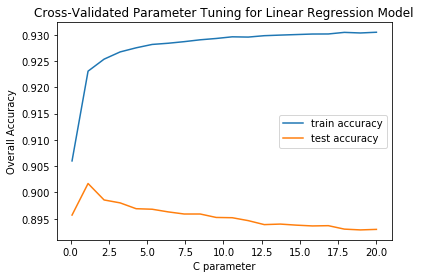

In [15]:
# Visualizing the effect on Logistic Regression Classifier of tuning 'C'
train_scr = []
test_scr = []
cv_space = np.linspace(1e-1,2e1,20)
for c in cv_space:
    scores = cross_validate(LogisticRegression(
        C=c,
        multi_class='ovr',
        solver='liblinear'),
        X_train_cv1,
        y_train,
        scoring='accuracy',
        return_train_score=True,
        cv=skf)
    train_scr.append(scores['train_score'].mean())
    test_scr.append(scores['test_score'].mean())

plt.plot(cv_space,train_scr, label='train accuracy')
plt.plot(cv_space, test_scr, label='test accuracy')
plt.title('Cross-Validated Parameter Tuning for Linear Regression Model')
plt.ylabel('Overall Accuracy')
plt.xlabel('C parameter')
plt.legend()
plt.show();

All other parameters the same, there is a hinge in the `C` parameter at roughly 0.35.

## Multinomial Naive Bayes
Getting baseline scores for some Naive Bayes models.

In [16]:
mnb_cv1 = MultinomialNB()
mnb_cv1 = cross_val_and_test(X_train_cv1, y_train, X_test_cv1, y_test, model=mnb_cv1, cv=skf)

Cross-Validation on training set:

Training score:   0.8939146300239278
Validation score: 0.8814698555130294
Test set results:

              precision    recall  f1-score   support

           0       0.46      0.31      0.37       286
           1       0.92      0.94      0.93      3838
           2       0.80      0.80      0.80       833

   micro avg       0.88      0.88      0.88      4957
   macro avg       0.73      0.68      0.70      4957
weighted avg       0.87      0.88      0.87      4957



## Logistic Regression With LDA Text Feature Minimization

### Latent Dirichlet Allocation
From here we could take the count vectorizer on its own and run a classifier on these words. Be it logistic regression, SVM, or a Naive Bayes (originally Bernoulli but probably Multinomial now that we are also using tweet features).  

However, I want to reduce this to a manageable number of features using some sort of decomposition. 

In [17]:
print('(No. of docs, No. of terms) :', X_vec.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus1 = matutils.Sparse2Corpus(X_vec.transpose())

# Create mapping of terms to indices
id2word1 = dict((v, k) for k, v in cv1.vocabulary_.items())

# show Term/Document matrix
# pd.DataFrame(X_vec.transpose().toarray(), index = cv1.get_feature_names()).head()

# Create lda model (equivalent to "fit" in sklearn)
n_topics_lda = 8
lda1 = models.LdaModel(corpus=corpus1, num_topics=n_topics_lda, id2word=id2word1, passes=10)
lda1.print_topics()

(No. of docs, No. of terms) : (19826, 1107)


[(0,
  '0.165*"pussy" + 0.024*"day" + 0.021*"eat" + 0.019*"yellow" + 0.018*"big" + 0.018*"good" + 0.017*"fag" + 0.016*"boy" + 0.016*"best" + 0.016*"old"'),
 (1,
  '0.101*"ass" + 0.082*"bitch" + 0.041*"fucking" + 0.030*"faggot" + 0.026*"fuck" + 0.019*"nigga" + 0.019*"hoe" + 0.019*"gonna" + 0.018*"hate" + 0.017*"dumb"'),
 (2,
  '0.142*"hoes" + 0.076*"hoe" + 0.023*"ain" + 0.023*"bird" + 0.023*"got" + 0.015*"just" + 0.015*"lol" + 0.013*"new" + 0.013*"bout" + 0.012*"right"'),
 (3,
  '0.046*"like" + 0.035*"bitch" + 0.035*"look" + 0.023*"got" + 0.022*"niggah" + 0.021*"ghetto" + 0.018*"just" + 0.018*"talking" + 0.016*"ve" + 0.015*"damn"'),
 (4,
  '0.232*"bitch" + 0.046*"like" + 0.038*"fuck" + 0.018*"ya" + 0.015*"little" + 0.014*"just" + 0.012*"lil" + 0.011*"like bitch" + 0.011*"ll" + 0.010*"lol"'),
 (5,
  '0.102*"don" + 0.070*"bitch" + 0.040*"ain" + 0.023*"hoe" + 0.020*"know" + 0.016*"like" + 0.015*"ho" + 0.014*"da" + 0.014*"did" + 0.013*"shit"'),
 (6,
  '0.071*"trash" + 0.055*"bitch" + 0.043*

LDA requires that I set the number of topics to fit to ahead of time. While I started with 3 topics because of the 3 classes in the dataset, I didn't find any distinguishable topics. Having run fits ranging anywhere from 2 to 10 topics, no interpretable topics jump out. The corpus of tweets is mainly labelled as offensive language, so we do see words like *bitch* or *bitches* interspersed throughout the topics. 

Using only the n-grams found in hateful tweets, we see clearer topic distinctions. With only two topics, the insults are mostly made up of slurs for gay and black people. Increasing the number of topics amplifies these distinctions and creates topics that receive contributions from other racial slurs.

In [20]:
# Using only hateful vocab
# Convert sparse matrix of counts to a gensim corpus
corpus2 = matutils.Sparse2Corpus(X_vec_2.transpose())

id2word2 = dict((v, k) for k, v in cv2.vocabulary_.items())

n_hate_topics = 5
lda2 = models.LdaModel(corpus = corpus2, num_topics=n_hate_topics, id2word=id2word2, passes=10 )
lda2.print_topics()

[(0,
  '0.386*"niggers" + 0.360*"fags" + 0.040*"wetbacks" + 0.022*"blacks" + 0.001*"nigger" + 0.001*"faggots" + 0.001*"faggot" + 0.001*"raped" + 0.001*"dykes" + 0.001*"spic"'),
 (1,
  '0.848*"nigger" + 0.001*"blacks" + 0.001*"niggers" + 0.001*"spic" + 0.001*"faggot" + 0.001*"chink" + 0.001*"raped" + 0.001*"faggots" + 0.001*"fags" + 0.001*"wetbacks"'),
 (2,
  '0.672*"faggot" + 0.188*"faggots" + 0.028*"spic" + 0.025*"raped" + 0.023*"dykes" + 0.000*"homo" + 0.000*"chink" + 0.000*"whites" + 0.000*"savages" + 0.000*"chinks"'),
 (3,
  '0.119*"chink" + 0.112*"chinks" + 0.110*"wetback" + 0.101*"savages" + 0.071*"inbred" + 0.061*"whites" + 0.003*"spic" + 0.002*"faggots" + 0.002*"raped" + 0.002*"faggot"'),
 (4,
  '0.182*"homo" + 0.176*"queers" + 0.066*"slave" + 0.003*"faggot" + 0.003*"raped" + 0.003*"faggots" + 0.003*"wetbacks" + 0.003*"dykes" + 0.003*"spic" + 0.003*"niggers"')]

### LDA Topics as Classifier Features
Beyond just looking at the ways in which people demean eachother online, the topics can ideally be used as a type of decomposition in order to reduce the features needed for the classifier. In theory this would be better down the line for mitigating any overfitting from having so many features.  

In practice, this only degrades the classifier performance. We see a drop in accuracy and F1 scores after making the appropriate transformations to the word counts for each observation. The results using topic modeling on the hategrams are worse and are not shown.

In [21]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus_train = lda1[corpus1]
corpus1_test = matutils.Sparse2Corpus(cv1.transform(X_test.text).transpose())
lda_corpus_test = lda1[corpus1_test]

# Turn documents into topic representation
lda_docs_train = [doc for doc in lda_corpus_train]
lda_docs_test = [doc for doc in lda_corpus_test]

In [22]:
# Merging training features with LDA topic reduction and twitter features
lda1_df_train = lda_to_array(lda_docs_train,n_topics_lda, True)
X_train_lda1 = pd.merge(X_train,lda1_df_train, on=lda1_df_train.index)
X_train_lda1.drop(columns = ['key_0', 'text'], inplace=True)

# Merging test features with LDA topic reduction and twitter features
lda1_df_test = lda_to_array(lda_docs_test,n_topics_lda, True)
X_test_lda1 = pd.merge(X_test,lda1_df_test, on=lda1_df_test.index)
X_test_lda1.drop(columns = ['key_0', 'text'], inplace=True)

#X_train_lda1.head()

# Logistic Regression, using ngrams from all words in text and twitter entity features
lr_lda1_ft = LogisticRegression(solver='liblinear', multi_class='ovr')
lf_lda1_f1 = cross_val_and_test(X_train_lda1, y_train, X_test_lda1, y_test, lr_lda1_ft, cv=skf)

Cross-Validation on training set:

Training score:   0.782873509137102
Validation score: 0.7830629019256742
Test set results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.79      0.98      0.88      3838
           2       0.56      0.12      0.20       833

   micro avg       0.78      0.78      0.78      4957
   macro avg       0.45      0.37      0.36      4957
weighted avg       0.71      0.78      0.71      4957



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Alternative Text Transformations - TFIDF
Rather than pure counts of a word in a document, TFIDF normalizes scores for the mean value of the row. It's a way of standardizing transformations for all documents in a corpus that accounts for the document lenght.  

Classifier performance is comparable to when using the count vectorizer data container, with accuracy and weighted F1 scores in the 0.9 range.

In [24]:
# Fit TFIDF on training data
tfidf = TfidfVectorizer(analyzer='word', stop_words=full_stop_words, min_df = 0.001).fit(X_train.text)

# Store text data tfidf for later decomposition
tfidf_train = tfidf.transform(X_train.text)
tfidf_test = tfidf.transform(X_test.text)

# Add back TFIDF to twitter features and test classifier
X_train_tfidf = prep_nlp_df(X_train, transformer=tfidf, text_col='text', drop_cols=['text'])
X_test_tfidf = prep_nlp_df(X_test, transformer=tfidf, text_col='text', drop_cols=['text'])

# Create classifier and get scores
lgr_tfidf = LogisticRegression(C=5, solver='liblinear',multi_class='ovr' )
lgr_tfidf = cross_val_and_test(X_train_tfidf, y_train, X_test_tfidf, y_test, model=lgr_tfidf, cv=skf)

Making features from provided transformer and data...
Making features from provided transformer and data...
Cross-Validation on training set:

Training score:   0.9199032243892178
Validation score: 0.8965008731011924
Test set results:

              precision    recall  f1-score   support

           0       0.52      0.20      0.29       286
           1       0.92      0.96      0.94      3838
           2       0.84      0.86      0.85       833

   micro avg       0.90      0.90      0.90      4957
   macro avg       0.76      0.67      0.69      4957
weighted avg       0.88      0.90      0.89      4957



## NMF
Non-nuclear matrix Factorization (NMF) is another way to decompose the document-term matrix into topics for a corpus of text documents. I've used it here with the TF-IDF count vectorizer, although we see similar degradations in accuracy compared to the classifier performance using the TF-IDF features.

In [25]:
# Build NMF model and create reductions for train and test sets
n_topics = 11
nmf_model = NMF(n_topics).fit(tfidf_train)
dtm_nmf_train = nmf_model.transform(tfidf_train)
dtm_nmf_test = nmf_model.transform(tfidf_test)
#dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf) # Skip normalization for now

# 
nmf_df_train = pd.DataFrame(dtm_nmf_train, columns = ['nmf_%s' % i for i in range(n_topics)])
nmf_df_test = pd.DataFrame(dtm_nmf_test, columns = ['nmf_%s' % i for i in range(n_topics)])

X_train_nmf = prep_nlp_df(X_train, nmf_df_train, text_col='text', drop_cols=['text'])
X_test_nmf = prep_nlp_df(X_test, nmf_df_test, text_col='text', drop_cols=['text'])

X_train_nmf.head()

,n_rt,mention,link,n_emoji,n_char,avg_wrd,emoji,retweet,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,nmf_9,nmf_10
0,0,0,0,0,23,3.80,0,0,0.000172,0.000000,0.0000,0.000000,0.145929,0.003209,0.001117,0.000291,0.000473,0.000000,0.001696
1,0,0,0,0,37,4.43,0,0,0.000000,0.000000,0.0000,0.003695,0.000000,0.000473,0.000000,0.003458,0.000000,0.000700,0.052057
2,0,0,0,2,24,4.75,1,0,0.000000,0.168631,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,1,0,0,25,4.00,0,0,0.083694,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.239045,0.000000
4,0,1,0,0,17,4.67,0,0,0.072678,0.001770,0.0007,0.009505,0.000000,0.002852,0.000998,0.000000,0.000000,0.002608,0.006249


In [26]:
# Logistic Regression, using ngrams from all words in text and twitter entity features
lr_nmf = LogisticRegression(solver='liblinear', multi_class='ovr')
lr_nmf = cross_val_and_test(X_train_nmf,y_train,X_test_nmf,y_test,model=lr_cv1_ft, cv=skf)

Cross-Validation on training set:

Training score:   0.7915742258840416
Validation score: 0.7914859989893943
Test set results:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.80      0.99      0.89      3838
           2       0.68      0.18      0.29       833

   micro avg       0.80      0.80      0.80      4957
   macro avg       0.49      0.39      0.39      4957
weighted avg       0.74      0.80      0.73      4957



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusions and Visualizations
From the above, my efforts to reduce ngram features into topics leaves too much information on the table for the classifier to perform as accurately as before. Because I know that I'll have several thousand examples to look through on Twitter, I'm ok with retaining several hundred features.  

Exporting all the components needed to run this model on new data:
* fitted count vectorizer object
* trained model: logistic regression, cv_1



In [27]:
model_pkl = {'model': lr_cv1,
            'transformer':cv1}

with open('bestmodel.pkl', 'wb') as f:
    pkl.dump(model_pkl, f)

### Most important classifier features
We can pull out the most important features for each class in the data using the trained logistic regression classifier. The model is trained in a "one vs all" fashion, meaning that each feature set is used to distinguish that topic from the rest of the tweets as a binary classifier. Recall that the classes are as follows:
* 0: hate speech
* 1: offensive language
* 2: non-offensive

In [29]:
# Looking at most important features for each class, leveraging Series' index:
# Get all n-grams from Count Vectorizer object, use sorted model coefficients as index
label, top_n = 0, 10
features = pd.Series(cv1.get_feature_names())[pd.Series(lr_cv1.coef_[label]).sort_values(ascending=False).index]
features[:top_n]

328    faggots
696    niggers
329       fags
327     faggot
695     nigger
771      queer
300       dyke
326        fag
543       kill
208       coon
dtype: object

# Visualizations for Topic Modeling
[This package](https://github.com/bmabey/pyLDAvis) offers interactive LDA topic visualizations using objects from Gensim.

In [30]:
# LDA for all text
cv_all = CountVectorizer(ngram_range=(1,3),
                      token_pattern="\\b[a-z][a-z]+\\b",
                      stop_words = full_stop_words,
                      max_df = 0.9,
                      min_df = 0.001)
counts_all = cv_all.fit_transform(tweet_df.text)


print('(No. of docs, No. of terms) :', X_vec.shape)

# Convert sparse matrix of counts to a gensim corpus
corpus_all = matutils.Sparse2Corpus(counts_all.transpose())

# Create mapping of terms to indices
id2word_all = dict((v, k) for k, v in cv_all.vocabulary_.items())


# show Term/Document matrix
# pd.DataFrame(X_vec.transpose().toarray(), index = cv1.get_feature_names()).head()

# Create lda model (equivalent to "fit" in sklearn)
n_topics_lda = 8
lda_all = models.LdaModel(corpus=corpus_all, num_topics=n_topics_lda, id2word=id2word_all, passes=10)
lda_all.print_topics()

# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corp_all = lda_all[corpus_all]

# Turn documents into topic representation
lda_docs = [doc for doc in lda_corp_all]

# Merging training features with LDA topic reduction and twitter features
tweets_lda = lda_to_array(lda_docs,n_topics_lda, False)

(No. of docs, No. of terms) : (19826, 1107)


In [32]:
tokenized_corpus = [[lda_all.id2word[word[0]] for word in doc] for doc in corpus_all]

pyLDAvis.gensim.prepare(lda_all, corpus_all, corpora.Dictionary(tokenized_corpus))

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.130843 -0.115438       1        1  14.864481
0      0.158853  0.169909       2        1  12.991385
5     -0.133002  0.017002       3        1  12.772259
1      0.044658  0.230715       4        1  12.637708
4      0.242719  0.020313       5        1  11.971649
6     -0.156976  0.071153       6        1  11.957701
2     -0.233534 -0.086112       7        1  11.771938
7      0.208126 -0.307543       8        1  11.032879, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
81    Default  8122.000000             want  8122.000000  30.0000  30.0000
108   Default  3244.000000               em  3244.000000  29.0000  29.0000
464   Default  2504.000000       bitch lmao  2504.000000  28.0000  28.0000
566   Default  2807.000000          redneck  2807.000000  27.0000  27.0000
461   Default  1965.000000             ones  1965.000000  26.0000  26.0000
752   Default  2062.000000             slow  2062.000000  25.0000  25.0000
35    Default  1503.000000             hate  1503.000000  24.0000  24.0000
410   Default  1150.000000            fight  1150.000000  23.0000  23.0000
593   Default  1031.000000           giving  1031.000000  22.0000  22.0000
968   Default  1244.000000            block  1244.000000  21.0000  21.0000
268   Default  1446.000000              ran  1446.000000  20.0000  20.0000
1082  Default   658.000000           random   658.000000  19.0000  19.0000
677   Default   881.000000       shit bitch   881.000000  18.0000  18.0000
673   Default  1258.000000          working  1258.000000  17.0000  17.0000
370   Default  1244.000000              guy  1244.000000  16.0000  16.0000
407   Default   518.000000              bae   518.000000  15.0000  15.0000
495   Default   514.000000           friday   514.000000  14.0000  14.0000
596   Default   494.000000            photo   494.000000  13.0000  13.0000
77    Default   420.000000       bitch fuck   420.000000  12.0000  12.0000
1014  Default   635.000000            dream   635.000000  11.0000  11.0000
9     Default   954.000000              dat   954.000000  10.0000  10.0000
51    Default   554.000000              yea   554.000000   9.0000   9.0000
952   Default   443.000000          support   443.000000   8.0000   8.0000
251   Default   336.000000              don   336.000000   7.0000   7.0000
666   Default   312.000000             song   312.000000   6.0000   6.0000
1046  Default   418.000000         crackers   418.000000   5.0000   5.0000
396   Default   318.000000            times   318.000000   4.0000   4.0000
767   Default   403.000000            green   403.000000   3.0000   3.0000
891   Default   314.000000             cock   314.000000   2.0000   2.0000
1079  Default   289.000000             jump   289.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
303    Topic8    91.395599              ask    92.254791   2.1949  -5.0065
633    Topic8    88.652245           nothin    89.511566   2.1946  -5.0370
963    Topic8    85.323204              rap    86.197403   2.1941  -5.0753
494    Topic8    83.670517            later    84.530083   2.1941  -5.0948
1022   Topic8    82.692398       bitch look    83.551903   2.1940  -5.1066
643    Topic8    81.387161              job    82.246132   2.1938  -5.1225
3      Topic8    77.913086          shouldn    78.772087   2.1933  -5.1661
681    Topic8    73.369041            uncle    74.228134   2.1926  -5.2262
717    Topic8    73.096817             main    73.955971   2.1926  -5.2299
724    Topic8    72.581955             room    73.441307   2.1925  -5.2370
1      Topic8    72.375572            house    73.234467   2.1925  -5.2398
492    Topic8    72.388420            drink    73.247643   2.1925  -5.2397
940    Topic8    69.251160             jok

## TSNE
TSNE is a clustering method for visualizing higher dimensional data. The distances between points don't translate to any physical meaning but it does serve a purpose for visualizing groupings. In the specifc case here we don't observe any major groupings that separate the classes of data: offensive tweets (blue), hate speech tweets (red), and neither (green) don't cluster by label.

In [33]:
# Visualize in two dimensions with TSNE
tsne = TSNE(n_components=3)
storage = tsne.fit_transform(tweets_lda)
storage.shape

(24783, 3)

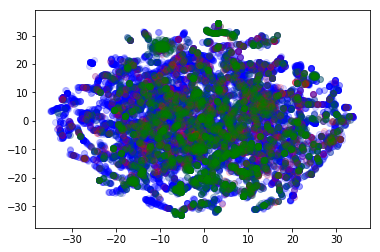

In [34]:
hate_mask = tweet_df['class']==0
off_mask = tweet_df['class'] ==1
safe = tweet_df['class'] ==2

plt.scatter(storage[off_mask,0], storage[off_mask,1], c='b', alpha=0.15)
plt.scatter(storage[hate_mask,0], storage[hate_mask,1], c='r', alpha=0.15)
plt.scatter(storage[safe,0], storage[safe,1], c='g', alpha=0.15)


In [35]:
# Saving TSNE data for visualization with plotly
filename = './data/LDA_all.pkl'
write_out = open(filename, 'wb')
pkl.dump(storage, write_out)
write_out.close()